In [1]:
import numpy as np 
import pandas as pd 
import os

In [3]:
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import sys
import argparse
import copy, json, os
from time import gmtime, strftime
import torch
from torch import nn, optim
import torch.nn.functional as F
import tensorflow as tf
from torchtext import data
import torchtext
from torchtext import datasets
from torchtext.vocab import GloVe
import nltk
from tensorboardX import SummaryWriter

ModuleNotFoundError: No module named 'torchtext'

# 一、定义初始变量参数

In [6]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--char-dim', default=8, type=int)
    # char-dim 默认值是8
    parser.add_argument('--char-channel-width', default=5, type=int)
    # char-channel-width 默认值是5 以下类似
    parser.add_argument('--char-channel-size', default=100, type=int)
    parser.add_argument('--context-threshold', default=400, type=int)
    parser.add_argument('--dev-batch-size', default=100, type=int)
    parser.add_argument('--dev-file', default='dev-v1.1.json')
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--epoch', default=12, type=int)
    parser.add_argument('--exp-decay-rate', default=0.999, type=float)
    parser.add_argument('--gpu', default=0, type=int)
    parser.add_argument('--hidden-size', default=100, type=int)
    parser.add_argument('--learning-rate', default=0.5, type=float)
    parser.add_argument('--print-freq', default=250, type=int)
    parser.add_argument('--train-batch-size', default=60, type=int)
    parser.add_argument('--train-file', default='train-v1.1.json')
    parser.add_argument('--word-dim', default=100, type=int)
    args = parser.parse_args(args=[]) 
    return args

In [7]:
args = parse_args()

# 二、SQuAD问答数据预处理

## 1、查看数据集结构

SQuAD问答数据介绍：https://rajpurkar.github.io/SQuAD-explorer/
这个数据集有两个文件，验证集和测试集：train-v1.1.json，dev-v1.1.json

In [8]:
with open('data/squad/dev-v1.1.json', 'r', encoding='utf-8') as f:
        try:
            while True:
                line = f.readline() # 该方法每次读出一行内容
                if line:
                    print("type(line)",type(line)) # 直接打印就是字符串格式
                    r = json.loads(line)
                    print("type(r)",type(r)) # 使用json.loads将字符串转化为字典
                    print(r)
                else:
                    break
        except:
            f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data/squad/dev-v1.1.json'

In [9]:
# 数据架构如下
{
    "data": [
        {
            "title": "Super_Bowl_50", # 第一个主题
            "paragraphs": [
                {
                    "context": " numerals 50.......", # 每个主题会有很多context短文,这里只列出一个
                    "qas": [  # 这个列表里放问题和答案的位置，每篇context会有很有很多answer和question，这里只列出一个
                        {
                            "answers": [  # 一个问题会有三个答案，三个答案都是对的，只是在context不同或相同位置
                                {         # 下面三个答案都在相同的位置
                                    "answer_start": 177,  # 答案在文中的起始位置是第177的字符。
                                    "text": "Denver Broncos"
                                },
                                {
                                    "answer_start": 177,
                                    "text": "Denver Broncos"
                                },
                                {
                                    "answer_start": 177,
                                    "text": "Denver Broncos"
                                }
                            ],
                            "question": "Which NFL team represented the AFC at Super Bowl 50?",
                            "id": "56be4db0acb8001400a502ec"
                        }

                    ]
                }
                
            ]
        },
        
        {
            "title": "Warsaw", # 第二个主题
            "paragraphs":   
        },
        
        {
            "title": "Normans", # 第三个主题
            "paragraphs": 
        },
        
        {
            "title": "Nikola_Tesla", # 第四个主题
            "paragraphs": 
        },
        ........... # 还有很多
        
    ],
    "version": "1.1"
}

SyntaxError: invalid syntax (<ipython-input-9-91763e591b63>, line 38)

## 2、定义分词方法

In [10]:
def word_tokenize(tokens):
    tokens = [token.replace("''", '"').replace("``", '"') for token in nltk.word_tokenize(tokens)]
    # nltk.word_tokenize(tokens)分词，replace规范化引号，方便后面处理
    return tokens

## 3、清洗数据，并生成数据迭代器[](http://)

In [11]:
class SQuAD():
    def __init__(self, args):

        # 以下定好中间输出缓存文件的路径
        path = 'data/squad' 
        dataset_path = path + '/torch_text/' 
        train_examples_path = dataset_path + 'train_examples.pt'
        dev_examples_path = dataset_path + 'dev_examples.pt'

        print("preprocessing data files...")
        if not os.path.exists(f'{path}/{args.train_file}l'):
            # 字符串前以f开头表示在字符串内支持大括号内的 python 表达式
            # args.train_file = 'train-v1.1.json'
            print(f'{path}/{args.train_file}')
            self.preprocess_file(f'{path}/{args.train_file}')  
            # preprocess_file下面函数有定义，完成文件的预处理
        if not os.path.exists(f'{path}/{args.dev_file}l'):
            # args.dev_file = 'dev-v1.1.json'
            self.preprocess_file(f'{path}/{args.dev_file}')
            
        # 下面是用torchtext处理数据的步骤看不懂了，有知道的可以交流下   
        self.RAW = data.RawField()# 这个是完全空白的field，意味着不经过任何处理
        # explicit declaration for torchtext compatibility
        self.RAW.is_target = False
        self.CHAR_NESTING = data.Field(batch_first=True, tokenize=list, lower=True)
        self.CHAR = data.NestedField(self.CHAR_NESTING, tokenize=word_tokenize)
        self.WORD = data.Field(batch_first=True, tokenize=word_tokenize, lower=True, include_lengths=True)
        self.LABEL = data.Field(sequential=False, unk_token=None, use_vocab=False)

        dict_fields = {'id': ('id', self.RAW),
                       's_idx': ('s_idx', self.LABEL),
                       'e_idx': ('e_idx', self.LABEL),
                       'context': [('c_word', self.WORD), ('c_char', self.CHAR)],
                       'question': [('q_word', self.WORD), ('q_char', self.CHAR)]}

        list_fields = [('id', self.RAW), ('s_idx', self.LABEL), ('e_idx', self.LABEL),
                       ('c_word', self.WORD), ('c_char', self.CHAR),
                       ('q_word', self.WORD), ('q_char', self.CHAR)]

        if os.path.exists(dataset_path):
            print("loading splits...")
            train_examples = torch.load(train_examples_path)
            dev_examples = torch.load(dev_examples_path)

            self.train = data.Dataset(examples=train_examples, fields=list_fields)
            self.dev = data.Dataset(examples=dev_examples, fields=list_fields)
        else:
            print("building splits...")
             # 划分训练集和验证集
            self.train, self.dev = data.TabularDataset.splits(
                path=path,
                train=f'{args.train_file}l',
                validation=f'{args.dev_file}l',
                format='json',
                fields=dict_fields)

            os.makedirs(dataset_path)
            torch.save(self.train.examples, train_examples_path)
            torch.save(self.dev.examples, dev_examples_path)

        #cut too long context in the training set for efficiency.
        if args.context_threshold > 0:
            self.train.examples = [e for e in self.train.examples if len(e.c_word) <= args.context_threshold]

        print("building vocab...")
        self.CHAR.build_vocab(self.train, self.dev) # 字符向量没有设置vector
        self.WORD.build_vocab(self.train, self.dev, vectors=GloVe(name='6B', dim=args.word_dim))
        # 加载Glove向量，args.word_dim = 100

        print("building iterators...")
        device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() else "cpu")
        # 生成迭代器
        self.train_iter, self.dev_iter = \
            data.BucketIterator.splits((self.train, self.dev),
                                       batch_sizes=[args.train_batch_size, args.dev_batch_size],
                                       device=device,
                                       sort_key=lambda x: len(x.c_word))

    def preprocess_file(self,path):
        dump = []
        abnormals = [' ', '\n', '\u3000', '\u202f', '\u2009']
        # 空白无效字符列表

        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f) # 直接文件句柄转化为字典
            data = data['data'] # 返回值data是个列表，字典是列表的元素

            for article in data:
                # 每个article是一个字典，一个字典包含一个title的信息
                for paragraph in article['paragraphs']:
                    # 每个paragraph是一个字典，一个字典里有一个context和qas的信息，qas是问题和答案。
                    context = paragraph['context']
                    # context的内容，是字符串，如：" numerals 50............."
                    tokens = word_tokenize(context) # 对context进行分词
                    for qa in paragraph['qas']:
                        # 每个qa是一个字典，一个字典包含一对answers和question的信息
                        id = qa['id']
                        # 取出这对answers和question的id信息，如："56be4db0acb8001400a502ec"
                        question = qa['question']
                        # 取出question，如："Which NFL team represented the AFC at Super Bowl 50?"
                        for ans in qa['answers']:
                            # ans为每个答案，共有三个标准答案，可以相同，可以不同，统一为3个。
                            answer = ans['text']
                            # 问题的每个回答，如："Denver Broncos"
                            s_idx = ans['answer_start']
                            # 每个回答的start位置，数值代表context中第几个字符，如：177
                            e_idx = s_idx + len(answer)
                            # 每个回答的end位置


                            # 下面重新更新字符的起始位置，使用字符计算位置改为使用单词计算位置
                            # 请看下面单元格的示例输出有助理解。
                            l = 0
                            s_found = False
                            for i, t in enumerate(tokens):
                                # 循环t次，t为分词后的单词数量
                                while l < len(context):
                                    if context[l] in abnormals:
                                        # context中有空白无效字符，就计数
                                        l += 1
                                    else:    # 一碰到不是空白字符的就break
                                        break
                                # exceptional cases
                                if t[0] == '"' and context[l:l + 2] == '\'\'':
                                    # 专门计算context=''an 这种长度，这个长度为4
                                    t = '\'\'' + t[1:] 
                                elif t == '"' and context[l:l + 2] == '\'\'':
                                    # 专门计算context='' 这种长度
                                    # 上面t[0] == '"'表达式包含了这种，所以我认为这个表达式没用上
                                    t = '\'\''

                                l += len(t)
                                if l > s_idx and s_found == False:
                                    # 只要计数超过起始位置值，这个单词就是start的单词
                                    s_idx = i
                                    s_found = True
                                if l >= e_idx:
                                    # 这里不出错的话，等于e_idx就是end的单词
                                    e_idx = i
                                    break

                            # 这里把三个answer分开，每个answer都放进字典中,并作为一个样本
                            dump.append(dict([('id', id),
                                              ('context', context),
                                              ('question', question),
                                              ('answer', answer),
                                              ('s_idx', s_idx),
                                              ('e_idx', e_idx)]))
        with open(f'{path}l', 'w', encoding='utf-8') as f:
            for line in dump:
                # line为字典，一个样本存储
                json.dump(line, f)
                #dump：将dict类型转换为json字符串格式，写入到文件
                print('', file=f) # 这里print的作用就是换行用的。

In [12]:
data = SQuAD(args)

preprocessing data files...
data/squad/train-v1.1.json


FileNotFoundError: [Errno 2] No such file or directory: 'data/squad/train-v1.1.json'

### 上面不太明白的举例子

In [13]:
# 举例子
a = " \u2009\n\u3000Super Bowl 50 was ''an'' American football     \u3000game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24\u201310 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the \"golden anniversary\" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as \"Super Bowl L\"), so that the logo could prominently feature the Arabic numerals 50."
tokens = word_tokenize(a)
print(nltk.word_tokenize(a)) # 所有的“\u2009”，“\n”，“\u3000”等空白字符都去掉了
print("----"*20)
print(tokens)

['Super', 'Bowl', '50', 'was', '``', 'an', "''", 'American', 'football', 'game', 'to', 'determine', 'the', 'champion', 'of', 'the', 'National', 'Football', 'League', '(', 'NFL', ')', 'for', 'the', '2015', 'season', '.', 'The', 'American', 'Football', 'Conference', '(', 'AFC', ')', 'champion', 'Denver', 'Broncos', 'defeated', 'the', 'National', 'Football', 'Conference', '(', 'NFC', ')', 'champion', 'Carolina', 'Panthers', '24–10', 'to', 'earn', 'their', 'third', 'Super', 'Bowl', 'title', '.', 'The', 'game', 'was', 'played', 'on', 'February', '7', ',', '2016', ',', 'at', 'Levi', "'s", 'Stadium', 'in', 'the', 'San', 'Francisco', 'Bay', 'Area', 'at', 'Santa', 'Clara', ',', 'California', '.', 'As', 'this', 'was', 'the', '50th', 'Super', 'Bowl', ',', 'the', 'league', 'emphasized', 'the', '``', 'golden', 'anniversary', "''", 'with', 'various', 'gold-themed', 'initiatives', ',', 'as', 'well', 'as', 'temporarily', 'suspending', 'the', 'tradition', 'of', 'naming', 'each', 'Super', 'Bowl', 'game'

In [14]:
print(a[0]) # 空白字符打印不出来
print(a[1]) # 空白字符打印不出来
print(a[2]) # 空白字符打印不出来
print(a[3]) # 空白字符打印不出来
print(a[4]) 
print(a[5])
a[1] 

 
 


　
S
u


'\u2009'

In [15]:
# 下面特别注意
print(tokens[4][0]== '"') # 虽然切分后看起来是"''"，但实际上是'"'
print(tokens[4][0]== "''") 
print(tokens[5]== '"')
print(len('"')) # 这种长度为1
print(len("''")) # 这种长度为2

True
False
False
1
2


In [16]:
# 查看输出理解
s_idx = 177
e_idx = s_idx + len("Denver Broncos")
l=0
context = " \u2009\n\u3000Super Bowl 50 was ''an'' American football     \u3000game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24\u201310 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the \"golden anniversary\" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as \"Super Bowl L\"), so that the logo could prominently feature the Arabic numerals 50."
tokens = word_tokenize(context)
abnormals = [' ', '\n', '\u3000', '\u202f', '\u2009']
s_found = False
for i, t in enumerate(tokens):
    print("t=",t)
    while l < len(context):
        if context[l] in abnormals:
            l += 1
        else:
            break
    print("l",l)
    # exceptional cases
    if t[0] == '"' and context[l:l + 2] == '\'\'':
        print("1111111111111111111")
        print(t)
        print(t[1:])
        t = '\'\'' + t[1:]
        print(t)
    elif t == '"' and context[l:l + 2] == '\'\'':
        # 看输出结果，这个表达式没有用到
        print("22222222222222222222")
        print(t)
        t = '\'\''
    print("len(t)",len(t))
    l += len(t)
    print("l",l)
    if l > s_idx and s_found == False:
        s_idx = i
        print("s_idx",s_idx)
        s_found = True
    if l >= e_idx:
        e_idx = i
        print("e_idx",e_idx)
        break

t= Super
l 4
len(t) 5
l 9
t= Bowl
l 10
len(t) 4
l 14
t= 50
l 15
len(t) 2
l 17
t= was
l 18
len(t) 3
l 21
t= "
l 22
1111111111111111111
"

''
len(t) 2
l 24
t= an
l 24
len(t) 2
l 26
t= "
l 26
1111111111111111111
"

''
len(t) 2
l 28
t= American
l 29
len(t) 8
l 37
t= football
l 38
len(t) 8
l 46
t= game
l 52
len(t) 4
l 56
t= to
l 57
len(t) 2
l 59
t= determine
l 60
len(t) 9
l 69
t= the
l 70
len(t) 3
l 73
t= champion
l 74
len(t) 8
l 82
t= of
l 83
len(t) 2
l 85
t= the
l 86
len(t) 3
l 89
t= National
l 90
len(t) 8
l 98
t= Football
l 99
len(t) 8
l 107
t= League
l 108
len(t) 6
l 114
t= (
l 115
len(t) 1
l 116
t= NFL
l 116
len(t) 3
l 119
t= )
l 119
len(t) 1
l 120
t= for
l 121
len(t) 3
l 124
t= the
l 125
len(t) 3
l 128
t= 2015
l 129
len(t) 4
l 133
t= season
l 134
len(t) 6
l 140
t= .
l 140
len(t) 1
l 141
t= The
l 142
len(t) 3
l 145
t= American
l 146
len(t) 8
l 154
t= Football
l 155
len(t) 8
l 163
t= Conference
l 164
len(t) 10
l 174
t= (
l 175
len(t) 1
l 176
t= AFC
l 176
len(t) 3
l 179
s_idx 32
t= )
l 1

In [17]:
batch = next(iter(data.train_iter)) #一个batch的信息
print(batch)
# 训练集的batch_sizes=60
# batch.c_word = 60x293，293是60个样本中最长样本token的单词数
# batch.c_char = 60x293x25，25是某个单词字符的最大的数量

AttributeError: module 'torchtext.data' has no attribute 'train_iter'

In [ ]:
print(batch.q_word)
print(batch.q_char[0])

In [ ]:
# 下面为args新增参数，并赋值
# hasattr() getattr() setattr() 函数使用方法详解https://www.cnblogs.com/cenyu/p/5713686.html
setattr(args, 'char_vocab_size', len(data.CHAR.vocab)) # 设置属性args.char_vocab_size的值 = len(data.CHAR.vocab)
setattr(args, 'word_vocab_size', len(data.WORD.vocab))
setattr(args, 'dataset_file', f'data/squad/{args.dev_file}')
setattr(args, 'prediction_file', f'prediction{args.gpu}.out')
setattr(args, 'model_time', strftime('%H:%M:%S', gmtime())) # 时间
print('data loading complete!')

## BIDAF

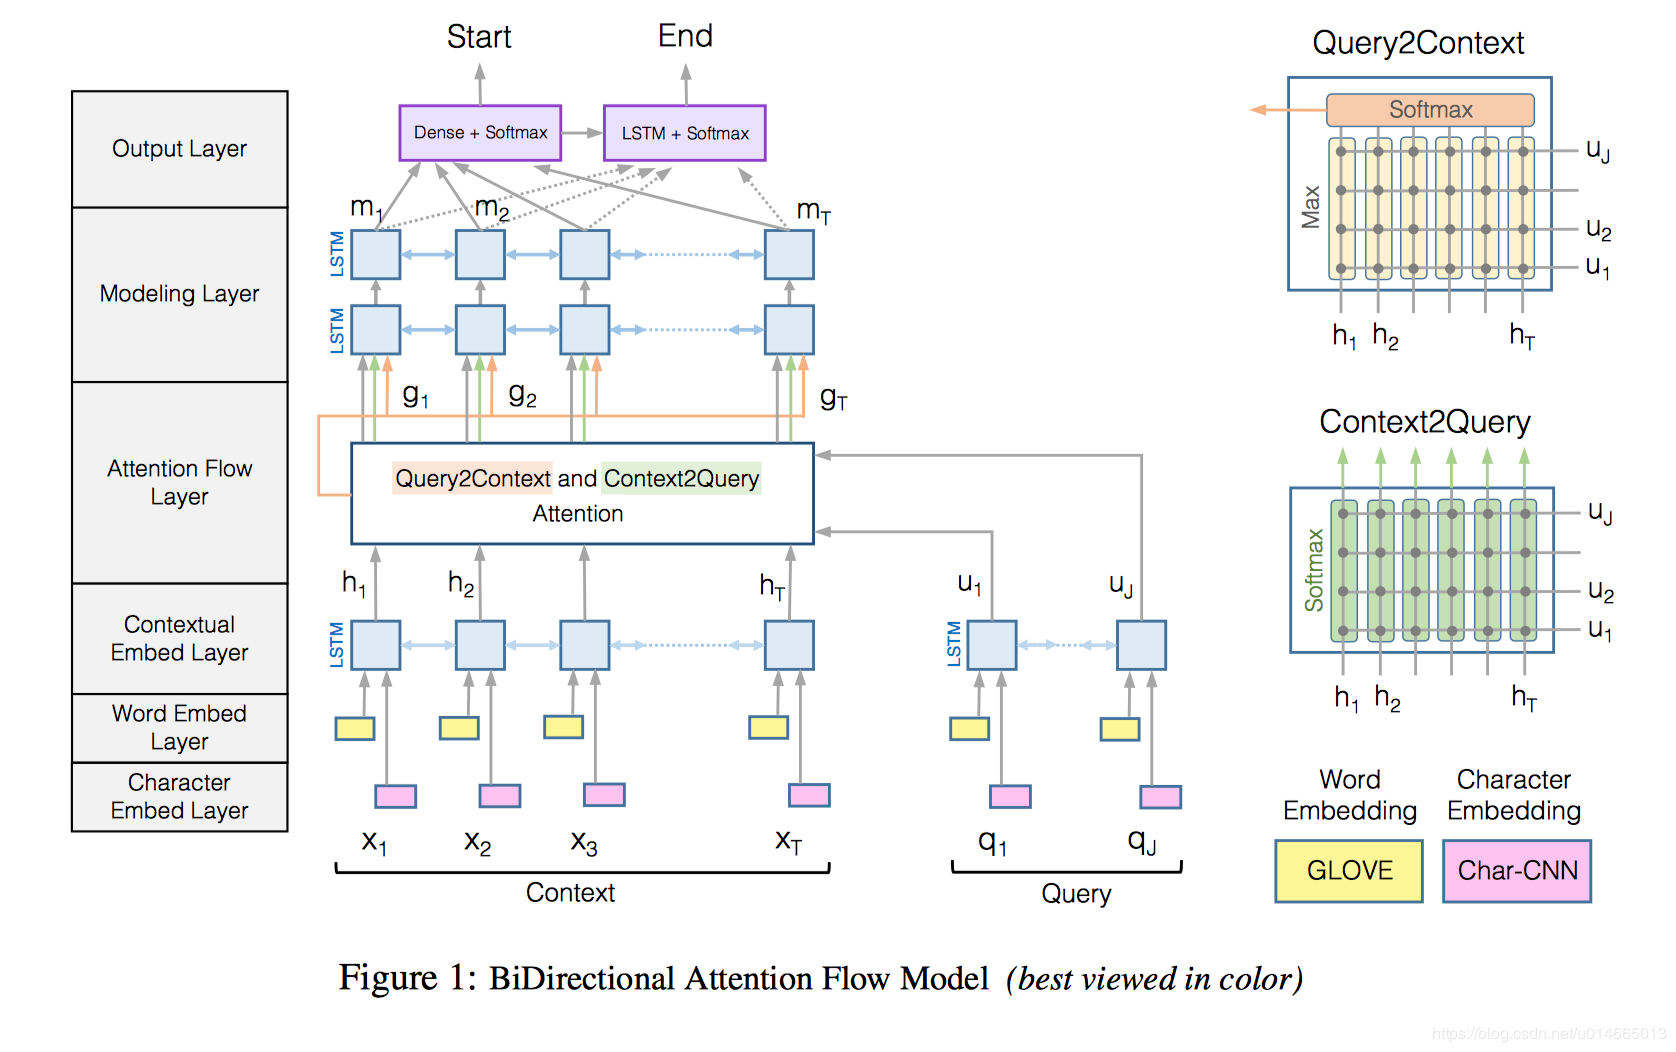

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, batch_first=False, num_layers=1, bidirectional=False, dropout=0.2):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           batch_first=batch_first)
        self.reset_params() # 重置参数
        self.dropout = nn.Dropout(p=dropout)

    def reset_params(self):
        for i in range(self.rnn.num_layers):
            nn.init.orthogonal_(getattr(self.rnn, f'weight_hh_l{i}')) # hidden-hidden weights
            # weight_hh_l{i}、weight_ih_l{i}、bias_hh_l{i}、bias_ih_l{i} 都是nn.LSTM源码里的参数
            # getattr取出源码里参数的值，用nn.init.orthogonal_正交进行重新初始化
            # nn.init初始化方法看这个链接：https://www.aiuai.cn/aifarm613.html
            nn.init.kaiming_normal_(getattr(self.rnn, f'weight_ih_l{i}')) # input-hidden weights
            nn.init.constant_(getattr(self.rnn, f'bias_hh_l{i}'), val=0) # hidden-hidden bias
            nn.init.constant_(getattr(self.rnn, f'bias_ih_l{i}'), val=0) # input-hidden bias
            getattr(self.rnn, f'bias_hh_l{i}').chunk(4)[1].fill_(1)
            # .chunk看下这个链接：https://blog.csdn.net/XuM222222/article/details/92380538
            # .fill_(1),下划线代表直接替换，看链接：https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.fill.html

            if self.rnn.bidirectional: # 双向，需要初始化反向的参数
                nn.init.orthogonal_(getattr(self.rnn, f'weight_hh_l{i}_reverse'))
                nn.init.kaiming_normal_(getattr(self.rnn, f'weight_ih_l{i}_reverse'))
                nn.init.constant_(getattr(self.rnn, f'bias_hh_l{i}_reverse'), val=0)
                nn.init.constant_(getattr(self.rnn, f'bias_ih_l{i}_reverse'), val=0)
                getattr(self.rnn, f'bias_hh_l{i}_reverse').chunk(4)[1].fill_(1)

    def forward(self, x):
        # x是一个元组(c, c_lens)
        x, x_len = x
        # x = (batch, seq_len, hidden_size * 2)
        # x_len = (batch) 一个batch中所有context或question的样本长度
        x = self.dropout(x)
        
        # 下面一顿操作和第七课机器翻译的一样，
        # 看下这篇博客理解：https://www.cnblogs.com/sbj123456789/p/9834018.html
        x_len_sorted, x_idx = torch.sort(x_len, descending=True)
        x_sorted = x.index_select(dim=0, index=x_idx)
        _, x_ori_idx = torch.sort(x_idx)

        x_packed = nn.utils.rnn.pack_padded_sequence(x_sorted, x_len_sorted, batch_first=True)
        x_packed, (h, c) = self.rnn(x_packed)

        x = nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)[0]
        x = x.index_select(dim=0, index=x_ori_idx)
        h = h.permute(1, 0, 2).contiguous().view(-1, h.size(0) * h.size(2)).squeeze()
        h = h.index_select(dim=0, index=x_ori_idx)
        # x = (batch, seq_len, hidden_size * 2)
        # h = (1, batch, hidden_size * 2) 这个维度不用管
        return x, h

In [ ]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.0):
        super(Linear, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        # in_features = hidden_size * 2
        # out_features = hidden_size * 2
        if dropout > 0:
            self.dropout = nn.Dropout(p=dropout)
        self.reset_params()

    def reset_params(self):
        nn.init.kaiming_normal_(self.linear.weight)
        nn.init.constant_(self.linear.bias, 0)

    def forward(self, x):
        if hasattr(self, 'dropout'): # 判断self有没有'dropout'这个参数，返回bool值
            x = self.dropout(x)
        x = self.linear(x)
        return x

In [ ]:
args.char_dim

In [ ]:
# 看英文论文或这篇博客理解模型：https://blog.csdn.net/u014665013/article/details/79793395
class BiDAF(nn.Module):
    def __init__(self, args, pretrained):
        # pretrained = data.WORD.vocab.vectors = (108777, 100)
        super(BiDAF, self).__init__()
        self.args = args

        # 1. Character Embedding Layer 是模型示意图左边的层的名字，从下往上
        # 字符编码层
        self.char_emb = nn.Embedding(args.char_vocab_size, args.char_dim, padding_idx=1)
        # args.char_vocab_size = 1307，args.char_dim = 8
        nn.init.uniform_(self.char_emb.weight, -0.001, 0.001)
        # 初始化权重

        self.char_conv = nn.Conv2d(1, args.char_channel_size, (args.char_dim, args.char_channel_width))
        # args.char_channel_size = 100 卷积核数量 
        # (args.char_dim, args.char_channel_width) = (8,5) 过滤器大小

        # 2. Word Embedding Layer
        # 单词编码层
        # initialize word embedding with GloVe
        self.word_emb = nn.Embedding.from_pretrained(pretrained, freeze=True)
        # 初始化词向量权重，用的Glove向量 

        # highway network
        assert self.args.hidden_size * 2 == (self.args.char_channel_size + self.args.word_dim)
        for i in range(2):
            setattr(self, f'highway_linear{i}',
                    nn.Sequential(Linear(args.hidden_size * 2, args.hidden_size * 2),
                                  nn.ReLU()))
            # 设置highway_linear0 = nn.Sequential(Linear(args.hidden_size * 2, args.hidden_size * 2)
            # 设置highway_linear1 = nn.Sequential(Linear(args.hidden_size * 2, args.hidden_size * 2)
            # args.hidden_size = 100
                                
            setattr(self, f'highway_gate{i}',
                    nn.Sequential(Linear(args.hidden_size * 2, args.hidden_size * 2),
                                  nn.Sigmoid()))

        # 3. Contextual Embedding Layer
        # 上下文，和答案嵌入层，用的LSTM
        # 下面LSTM定位到了自定义的class LSTM(nn.Module)。
        self.context_LSTM = LSTM(input_size=args.hidden_size * 2,
                                 hidden_size=args.hidden_size,
                                 bidirectional=True,
                                 batch_first=True,
                                 dropout=args.dropout) 

        # 4. Attention Flow Layer
        # 注意力层
        self.att_weight_c = Linear(args.hidden_size * 2, 1)
        self.att_weight_q = Linear(args.hidden_size * 2, 1)
        self.att_weight_cq = Linear(args.hidden_size * 2, 1)

        # 5. Modeling Layer
        self.modeling_LSTM1 = LSTM(input_size=args.hidden_size * 8,
                                   hidden_size=args.hidden_size,
                                   bidirectional=True,
                                   batch_first=True,
                                   dropout=args.dropout)

        self.modeling_LSTM2 = LSTM(input_size=args.hidden_size * 2,
                                   hidden_size=args.hidden_size,
                                   bidirectional=True,
                                   batch_first=True,
                                   dropout=args.dropout)

        # 6. Output Layer
        self.p1_weight_g = Linear(args.hidden_size * 8, 1, dropout=args.dropout)
        self.p1_weight_m = Linear(args.hidden_size * 2, 1, dropout=args.dropout)
        self.p2_weight_g = Linear(args.hidden_size * 8, 1, dropout=args.dropout)
        self.p2_weight_m = Linear(args.hidden_size * 2, 1, dropout=args.dropout)

        self.output_LSTM = LSTM(input_size=args.hidden_size * 2,
                                hidden_size=args.hidden_size,
                                bidirectional=True,
                                batch_first=True,
                                dropout=args.dropout)

        self.dropout = nn.Dropout(p=args.dropout)

    def forward(self, batch):
        # batch里面有'id','s_idx','e_idx', 'c_word','c_char','q_word', 'q_char'数据
        # TODO: More memory-efficient architecture
        def char_emb_layer(x):
            """
            :param x: (batch, seq_len, word_len)
            :return: (batch, seq_len, char_channel_size)
            """
            # x = (batch_sizes,seq_len,word_len)
            batch_size = x.size(0)
            x = self.dropout(self.char_emb(x))
            # (batch, seq_len, word_len, char_dim)
            x = x.view(-1, self.args.char_dim, x.size(2)).unsqueeze(1)
            # (batch * seq_len, 1, char_dim, word_len) 1是输入的channel的维度
            x = self.char_conv(x).squeeze()
            # (batch * seq_len, char_channel_size, 1, conv_len) -> 
            # (batch * seq_len, char_channel_size, conv_len) conv_len不用管，下一步都会pool掉
            x = F.max_pool1d(x, x.size(2)).squeeze()
            # (batch * seq_len, char_channel_size, 1) -> (batch * seq_len, char_channel_size)
            x = x.view(batch_size, -1, self.args.char_channel_size)
            # (batch, seq_len, char_channel_size)

            return x

        def highway_network(x1, x2):
            """
            :param x1: (batch, seq_len, char_channel_size)
            :param x2: (batch, seq_len, word_dim)
            :return: (batch, seq_len, hidden_size * 2)
            """
            
            x = torch.cat([x1, x2], dim=-1)
            # x = (batch, seq_len, char_channel_size + word_dim)
            for i in range(2):
                h = getattr(self, f'highway_linear{i}')(x) # 调用Linear的forward方法
                # h = (batch, seq_len, hidden_size * 2)
                g = getattr(self, f'highway_gate{i}')(x)
                # g = (batch, seq_len, hidden_size * 2)
                x = g * h + (1 - g) * x
            # (batch, seq_len, hidden_size * 2)
            return x

        def att_flow_layer(c, q):
            """
            :param c: (batch, c_len, hidden_size * 2)
            :param q: (batch, q_len, hidden_size * 2)
            :return: (batch, c_len, q_len)
            """
            c_len = c.size(1)
            q_len = q.size(1)

            # (batch, c_len, q_len, hidden_size * 2)
            #c_tiled = c.unsqueeze(2).expand(-1, -1, q_len, -1)
            # (batch, c_len, q_len, hidden_size * 2)
            #q_tiled = q.unsqueeze(1).expand(-1, c_len, -1, -1)
            # (batch, c_len, q_len, hidden_size * 2)
            #cq_tiled = c_tiled * q_tiled
            #cq_tiled = c.unsqueeze(2).expand(-1, -1, q_len, -1) * q.unsqueeze(1).expand(-1, c_len, -1, -1)
#        # 4. Attention Flow Layer
#         # 注意力层
#         self.att_weight_c = Linear(args.hidden_size * 2, 1)
#         self.att_weight_q = Linear(args.hidden_size * 2, 1)
#         self.att_weight_cq = Linear(args.hidden_size * 2, 1)
            cq = []
            # 1、相似度计算方式，看下这篇博客理解：https://blog.csdn.net/u014665013/article/details/79793395
            for i in range(q_len):
                qi = q.select(1, i).unsqueeze(1)
                # (batch, 1, hidden_size * 2)
                # .select看这个：https://blog.csdn.net/hungryof/article/details/51802829
                ci = self.att_weight_cq(c * qi).squeeze()
                # (batch, c_len, 1)
                cq.append(ci)
            cq = torch.stack(cq, dim=-1) 
            # (batch, c_len, q_len) cp是共享相似度矩阵
            
            
            # 2、计算对每一个 context word 而言哪些 query words 和它最相关。
            # context-to-query attention(C2Q):
            s = self.att_weight_c(c).expand(-1, -1, q_len) + \
                self.att_weight_q(q).permute(0, 2, 1).expand(-1, c_len, -1) + cq
            # (batch, c_len, q_len) 
            a = F.softmax(s, dim=2) 
            # (batch, c_len, q_len)
            c2q_att = torch.bmm(a, q) 
            # (batch, c_len, q_len) * (batch, q_len, hidden_size * 2) -> (batch, c_len, hidden_size * 2)
            
            
            # 3、计算对每一个 query word 而言哪些 context words 和它最相关
            # query-to-context attention(Q2C):
            b = F.softmax(torch.max(s, dim=2)[0], dim=1).unsqueeze(1)
            # (batch, 1, c_len)
            q2c_att = torch.bmm(b, c).squeeze()
            # (batch, 1, c_len) * (batch, c_len, hidden_size * 2) -> (batch, hidden_size * 2)
            q2c_att = q2c_att.unsqueeze(1).expand(-1, c_len, -1)
            # (batch, c_len, hidden_size * 2) (tiled)
            # q2c_att = torch.stack([q2c_att] * c_len, dim=1)
            
            
            # 4、最后将context embedding和C2Q、Q2C的结果（三个矩阵）拼接起来
            x = torch.cat([c, c2q_att, c * c2q_att, c * q2c_att], dim=-1)
            # (batch, c_len, hidden_size * 8)
            return x

        def output_layer(g, m, l):
            """
            :param g: (batch, c_len, hidden_size * 8)
            :param m: (batch, c_len ,hidden_size * 2)
             #  l = c_lens
            :return: p1: (batch, c_len), p2: (batch, c_len)
            """
            p1 = (self.p1_weight_g(g) + self.p1_weight_m(m)).squeeze()
            # (batch, c_len)
            m2 = self.output_LSTM((m, l))[0]
            # (batch, c_len, hidden_size * 2)
            p2 = (self.p2_weight_g(g) + self.p2_weight_m(m2)).squeeze()
            # (batch, c_len)
            return p1, p2

        # 1. Character Embedding Layer
        # 令:一个batch中单词数量最多的样本长度为seq_len
        # 令:一个batch中某个单词长度最长的单词长度为word_len
        
        c_char = char_emb_layer(batch.c_char) 
        # batch.c_char = (batch,seq_len,word_len) 后两个维度对应context
        # c_char = (batch, seq_len, char_channel_size)

        q_char = char_emb_layer(batch.q_char)
        # batch.c_char = (batch,seq_len,word_len) 后两个维度对应question
        # c_char = (batch, seq_len, char_channel_size)
        
        # 2. Word Embedding Layer
        c_word = self.word_emb(batch.c_word[0])
        # batch.c_word[0] = (batch,seq_len) 后一个维度对应context
        # c_word = (batch, seq_len, word_dim) word_dim是Glove词向量维度
        q_word = self.word_emb(batch.q_word[0]) 
        # batch.q_word[0] = (batch,seq_len) 后一个维度对应question
        # q_word = (batch, seq_len, word_dim)
        c_lens = batch.c_word[1]
        # c_lens：一个batch中所有context的样本长度
        q_lens = batch.q_word[1]
        # q_lens：一个batch中所有question的样本长度

        # Highway network
        c = highway_network(c_char, c_word)
        # c = (batch, seq_len, hidden_size * 2)
        q = highway_network(q_char, q_word)
        # q = (batch, seq_len, hidden_size * 2)
        
        # 3. Contextual Embedding Layer
        c = self.context_LSTM((c, c_lens))[0]
        # c = (batch, seq_len, hidden_size * 2)
        q = self.context_LSTM((q, q_lens))[0]
        # q = (batch, seq_len, hidden_size * 2)
        
        # 4. Attention Flow Layer
        g = att_flow_layer(c, q)
        # (batch, c_len, hidden_size * 8)
        
        # 5. Modeling Layer
        m = self.modeling_LSTM2((self.modeling_LSTM1((g, c_lens))[0], c_lens))[0]
        # self.modeling_LSTM1((g, c_lens))[0] = (batch, c_len, hidden_size * 2) # 2因为是双向
        # m = (batch, c_len, hidden_size * 2) 2因为是双向
        
        # 6. Output Layer
        p1, p2 = output_layer(g, m, c_lens) # 预测开始位置和结束位置
        # (batch, c_len), (batch, c_len)
        return p1, p2

In [ ]:
x = torch.rand((2,5,6))
print(x)
y = x.select(1, 2)
print(y)

In [ ]:
print(len(data.WORD.vocab)) # 108777个单词
print(data.WORD.vocab.vectors.shape) # 词向量维度

print(data.WORD.vocab.itos[:50]) # 前50个词频最高的单词
print("------"*10)
print(list(data.WORD.vocab.stoi.items())[0:50]) # 对应的索引

In [ ]:
print(len(data.CHAR.vocab)) # 1307个单词
print(data.CHAR.vocab.itos[:50]) # 108777个单词
print("------"*10)
print(list(data.CHAR.vocab.stoi.items())[0:50]) # 对应的索引

In [ ]:
device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() else "cpu")
model = BiDAF(args, data.WORD.vocab.vectors).to(device)

In [ ]:
class EMA():
    def __init__(self, mu):
        # mu = args.exp_decay_rate = 0.999
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        # name:各个参数层的名字, param.data；参数层的数据
        self.shadow[name] = val.clone() # 建立字典
        # clone()得到的Tensor不仅拷贝了原始的value，而且会计算梯度传播信息，copy_()只拷贝数值

    def get(self, name):
        return self.shadow[name]

    def update(self, name, x):
        assert name in self.shadow
        new_average = (1.0 - self.mu) * x + self.mu * self.shadow[name]
        self.shadow[name] = new_average.clone()

In [ ]:
def test(model, ema, args, data):
    device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    loss = 0
    answers = dict()
    model.eval()

    backup_params = EMA(0)
    for name, param in model.named_parameters():
        if param.requires_grad:
            backup_params.register(name, param.data) # 重新建立字典
            param.data.copy_(ema.get(name))

    with torch.set_grad_enabled(False):
        for batch in iter(data.dev_iter):
            p1, p2 = model(batch)
            print(p1.shape,p2.shape)
            print(batch.s_idx,batch.e_idx)
            batch_loss = criterion(p1, batch.s_idx-1) + criterion(p2, batch.e_idx-1)
            print("batch_loss",batch_loss)
            print("----"*40)
            loss += batch_loss.item()

            # (batch, c_len, c_len)
            batch_size, c_len = p1.size()
            ls = nn.LogSoftmax(dim=1)
            mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
            score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
            score, s_idx = score.max(dim=1)
            score, e_idx = score.max(dim=1)
            s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()

            for i in range(batch_size):
                id = batch.id[i]
                answer = batch.c_word[0][i][s_idx[i]:e_idx[i]+1]
                answer = ' '.join([data.WORD.vocab.itos[idx] for idx in answer])
                answers[id] = answer

        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data.copy_(backup_params.get(name))

    with open(args.prediction_file, 'w', encoding='utf-8') as f:
        print(json.dumps(answers), file=f)

    results = evaluate.main(args)
    return loss, results['exact_match'], results['f1']

In [ ]:
for name, param in model.named_parameters():
    print(name)
    print(param.requires_grad)
    print(param.data.shape)

In [ ]:
strftime('%H:%M:%S', gmtime()) 

In [ ]:
iterator = data.train_iter
n= 0
for j in range(2):
    print("j=",j)
    for i, batch in enumerate(iterator):
        print("当前epoch",int(iterator.epoch))
        print("-----"*10)
        print(i)
        print(batch)
        n+=1
        if n>3:
            break

In [ ]:
def train(args, data):
    device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() else "cpu")
    model = BiDAF(args, data.WORD.vocab.vectors).to(device) # 定义主模型类实例

    ema = EMA(args.exp_decay_rate) # args.exp_decay_rate = 0.999
    for name, param in model.named_parameters(): 
        if param.requires_grad:
            ema.register(name, param.data) # 参数名字和对应的参数数据形成字典
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    # p.requires_grad = True or False 保留有梯度的参数
    optimizer = optim.Adadelta(parameters, lr=args.learning_rate)
    # args.learning_rate = 0.5,优化器选用Adadelta
    criterion = nn.CrossEntropyLoss()
    # 交叉熵损失

    writer = SummaryWriter(log_dir='runs/' + args.model_time)
    # args.model_time = strftime('%H:%M:%S', gmtime()) 文件夹命名为写入文件的当地时间

    model.train()
    loss, last_epoch = 0, -1
    max_dev_exact, max_dev_f1 = -1, -1

    iterator = data.train_iter
    for i, batch in enumerate(iterator):
        present_epoch = int(iterator.epoch) 
        #print("当前epoch",present_epoch)# 这个我打印了下，一直是0，觉得有问题
        if present_epoch == args.epoch:
            # args.epoch=12
            break
        if present_epoch > last_epoch:
            print('epoch:', present_epoch + 1)
        last_epoch = present_epoch

        p1, p2 = model(batch)
        # (batch, c_len), (batch, c_len)

        optimizer.zero_grad()
        
        batch_loss = criterion(p1, batch.s_idx) + criterion(p2, batch.e_idx)
        # 最后的目标函数：batch.s_idx是答案开始的位置，batch.e_idx是答案结束的位置
        loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()

        for name, param in model.named_parameters():
            if param.requires_grad:
                ema.update(name, param.data) # 更新训练完后的的参数数据

        if (i + 1) % args.print_freq == 0:
            print("i",i)
            dev_loss, dev_exact, dev_f1 = test(model, ema, args, data)
            c = (i + 1) // args.print_freq

            writer.add_scalar('loss/train', loss, c)
            writer.add_scalar('loss/dev', dev_loss, c)
            writer.add_scalar('exact_match/dev', dev_exact, c)
            writer.add_scalar('f1/dev', dev_f1, c)
            print(f'train loss: {loss:.3f} / dev loss: {dev_loss:.3f}'
                  f' / dev EM: {dev_exact:.3f} / dev F1: {dev_f1:.3f}')

            if dev_f1 > max_dev_f1:
                max_dev_f1 = dev_f1
                max_dev_exact = dev_exact
                best_model = copy.deepcopy(model)

            loss = 0
            model.train()

    writer.close()
#     print(f'max dev EM: {max_dev_exact:.3f} / max dev F1: {max_dev_f1:.3f}')

    return best_model

In [ ]:
print('training start!')
best_model = train(args, data)